In [1]:
import sys

# import seaborn as sns
import numpy as np
from scipy import stats, integrate
import os
import matplotlib as mpl
import matplotlib.ticker as tk
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
import re
from copy import deepcopy
from astropy.io import fits
from matplotlib.backends.backend_pdf import PdfPages
import datetime
import pandas as pd
import scipy.interpolate as interpolate

plt.rcParams.update({'font.size': 18})
sys.path.append('/home/jtb34/GitHub/GACF/')
#sys.path.append('/home/jtb34/python27')
# print sys.path
from NGTS.NGTS_Field import return_field_from_object_directory, NGTSField
from NGTS.GACF_utils import TIME_CONVERSIONS
import NGTS.GACF_utils as utils

ROOT_DIR = '/home/jtb34/rds/hpc-work/GACF_OUTPUTS'

/home/jtb34/GitHub/GACF/NGTS/NGTS_Field.py:11: UserWarning: ngtsio not imported
  warnings.warn("ngtsio not imported")
/home/jtb34/GitHub/GACF/NGTS/GACF_utils/ngtsio_utils.py:10: UserWarning: ngtsio not imported
  warnings.warn("ngtsio not imported")


In [2]:
def do_plots(obj):
    n=4
    fig, ax = plt.subplots(2,2, figsize=(10, 5))
    ax[0,0].scatter(obj.timeseries_binned, obj.flux_binned, s=0.5)
    ax[1,0].scatter(obj.lag_timeseries, obj.correlations, s=0.5)
    ft_max = max(obj.ft)
    ax[0,1].plot(obj.period_axis, obj.ft/ft_max, lw=0.5, marker='.', ms=0.5)
    ax[0,1].set_xscale('log')
    ax[0,1].set_xlim(right=100)
    ax[0,1].scatter(obj.period_axis[obj.peak_indexes], obj.ft[obj.peak_indexes]/ft_max, marker='+', s=40, c='r')
    peaks = obj.ft[obj.peak_indexes] / ft_max
    peaksplot = np.linspace(1, len(peaks), len(peaks))
    ax[1,1].scatter(peaksplot, peaks)
    ft_ave = np.mean(obj.ft) / ft_max
    peaks_ave = np.mean(peaks)
    ax[1,1].axhline(y=ft_ave, c='g', label='FT mean')
    ax[1,1].axhline(y=peaks_ave, c='r', label='Peaks mean')
    plt.show()
    p = obj.cleaned_refined_periods[0]
    t = obj.timeseries_binned
    f = obj.flux_binned
    phase_app, data_app = utils.append_to_phase(utils.create_phase(t, p, new_moon_epoch), f)
    binned_phase_app, binned_data_app = utils.bin_phase_curve(phase_app, data_app)
    fig, ax = plt.subplots(figsize=(10,5))
    ax.scatter(phase_app, data_app, s=0.1)
    ax.scatter(binned_phase_app, binned_data_app, s=5, c='r')
    ax.axvline(x=0, lw=0.1, c='k', ls='--')
    ax.axvline(x=1, lw=0.1, c='k', ls='--')
    ax.set_title('Data phase folded on {} day period'.format(p))
    plt.show()

In [3]:
from scipy.signal import savgol_filter
def remove_moon_signal(t, f, ferr, P, epoch=137.0):
    """
    determine period and phase to fold on
    P = estimate from LS fits
    phase = same for all LCs - just set epoch=0? set to between moon peaks
    try:
        savitzky_golay(y, 51, 3) # window size 51, polynomial order 3
        or moving average from pandas
    subtract from f
    return f
    """
    medf = np.median(f)
    f = f - medf
    t2r, f2r, ferr2r = t, f, ferr

    # get flux in phase-order

    phase = np.mod(t - epoch, P) / P
    pidx = np.argsort(phase)

    tp = t[pidx]
    fp = f[pidx]
    fperr = ferr[pidx]

    def smooth(y, box_pts):
        box = np.ones(box_pts) / box_pts
        y_smooth = np.convolve(y, box, mode='same')
        return y_smooth

    # detrend for ‘moon’ signal: uses two-step process 
    # first scipy.signal.savgol_filter() followed by convolution (smooth())
    sgf = savgol_filter(fp, 151, 1, mode='wrap')  # window size 151, polynomial order 1
    sgf = smooth(sgf, 20)

    # re-order in time
    tidx = np.argsort(t)
    f2r = fp[tidx] - sgf[tidx]
    t2r = tp[tidx]
    ferr2r = fperr[tidx]

    # double-check ordering
    idx = np.argsort(t2r)
    t2r = t2r[idx]
    f2r = f2r[idx] + medf
    ferr2r = ferr2r[idx]

    if any(t2r[1:] - t2r[:-1] < 0.):
        raise ValueError("Re-ordering arrays back into time-order has failed somehow...")

    return t2r, f2r, ferr2r, sgf[tidx][idx] + medf

In [4]:
from astropy.time import Time
from astropy.coordinates import get_moon, get_sun
def moon_phase_angle(time, ephemeris=None):
    """
    Calculate lunar orbital phase in radians.

    Parameters
    ----------
    time : `~astropy.time.Time`
        Time of observation

    ephemeris : str, optional
        Ephemeris to use.  If not given, use the one set with
        `~astropy.coordinates.solar_system_ephemeris` (which is
        set to 'builtin' by default).

    Returns
    -------
    i : float
        Phase angle of the moon [radians]
    """
    # TODO: cache these sun/moon SkyCoord objects

    sun = get_sun(time)
    moon = get_moon(time, ephemeris=ephemeris)
    elongation = sun.separation(moon)
    return np.arctan2(sun.distance*np.sin(elongation),
                      moon.distance - sun.distance*np.cos(elongation))

def moon_illumination(time, ephemeris=None):
    """
    Calculate fraction of the moon illuminated.

    Parameters
    ----------
    time : `~astropy.time.Time`
        Time of observation

    ephemeris : str, optional
        Ephemeris to use.  If not given, use the one set with
        `~astropy.coordinates.solar_system_ephemeris` (which is
        set to 'builtin' by default).

    Returns
    -------
    k : float
        Fraction of moon illuminated
    """
    i = moon_phase_angle(time, ephemeris=ephemeris)
    k = (1 + np.cos(i))/2.0
    return k.value

In [5]:
def get_new_moon_epoch(timeseries):
    med_time = np.median(timeseries)
    moon_time = np.linspace(med_time - 30, med_time + 30, 100)
    moons = [moon_illumination(Time(t + utils.NGTS_EPOCH, format='jd')) for t in moon_time]
    moon_epoch = Time(moon_time[np.argmin(moons)], format='jd').jd
#     fig, ax = plt.subplots(figsize=(10,5))
#     ax.plot(moon_time, moons)
#     ax.axvline(x=moon_time[np.argmin(moons)])
    return moon_epoch, moon_time, moons

def check_moon_detection(obj, moon_epoch, period=None, shape_or_noise=True):
    is_moon = True
    if period is None:
        if len(obj.cleaned_refined_periods) > 0:
            period = obj.cleaned_refined_periods[0]
        else:
            is_moon = False
            print 'No Periods Found'
            return is_moon
    # is period within range 25 - 30 days?
    if not 25.0 < period < 32.0:
        is_moon = False
        print 'Rejected on Period Range'
        return is_moon
    # is there a noticable change in the LC around 0.5 phase from new moon?
    t = obj.timeseries_binned
    f = obj.flux_binned
    phase_app, data_app = utils.create_phase(t, period, moon_epoch), f
    binned_phase_app, binned_data_app = utils.bin_phase_curve(phase_app, data_app)
    idx_in = [i for i in range(len(phase_app)) if 0.4 < phase_app[i] < 0.6]
    idx_out = [i for i in range(len(phase_app)) if i not in idx_in]
    idx_in_bin = [i for i in range(len(binned_phase_app)) if 0.4 < binned_phase_app[i] < 0.6]
    idx_out_bin = [i for i in range(len(binned_phase_app)) if i not in idx_in_bin]
    med_out, sig_out = utils.medsig(data_app[idx_out])
    med_in, sig_in = utils.medsig(data_app[idx_in])
    mean_diff_in = np.mean(np.diff(binned_data_app[idx_in_bin]))
    mean_diff_out = np.mean(np.diff(binned_data_app[idx_out_bin]))
    fig, ax = plt.subplots(figsize=(10,5))
    ax.scatter(phase_app[idx_in], data_app[idx_in], s=0.1, c='r')
    ax.scatter(phase_app[idx_out], data_app[idx_out], s=0.1, c='g')
    ax.axhline(med_in, color='r')
    ax.axhline(med_out, color='g')
    ax.axhspan(med_in-sig_in, med_in+sig_in, color='r', alpha=0.2)
    ax.axhspan(med_out-sig_out, med_out+sig_out, color='g', alpha=0.2)
    plt.show()
#     print 'Outside: {} ± {}'.format(med_out, sig_out)
#     print 'Inside: {} ± {}'.format(med_in, sig_in)
    # does noise increase at full moon?
    if (not sig_in > sig_out):
        print 'Rejected on Noise'
        noise_crit = False
    else:
        print 'Noise criterion suggests moon'
        noise_crit = True
    # does signal increase / decrease at full moon?
    if (not abs(med_in - med_out) > sig_out):
        print 'Rejected on Signal Shape'
#         print 'Outside: {} ± {}'.format(med_out, sig_out)
#         print 'Inside: {} ± {}'.format(med_in, sig_in)
        shape_crit = False
#         if shape_or_noise:
#             is_moon = True if is_moon else False
#         else:
#             is_moon = False
    else:
        print 'Signal shape suggests moon'
        shape_crit = True
    # is signal less flat at full moon (larger differences)
    if mean_diff_in <= mean_diff_out:
        print 'Rejected on flatness'
        diff_crit = False
    else:
        print 'Flatness suggests moon'
        diff_crit = True
        
    is_moon = True if sum(1 for ct in [noise_crit, diff_crit, shape_crit] if ct) >=2 else False
    
    return is_moon
    

In [6]:
def check_fourier_ok(obj, nlim=20, peakpct=0.5, npeakstocheck=3, binary_check=0.8):
    is_ok = True
    ft_max = max(obj.ft)
    peaks = obj.ft[obj.peak_indexes] / ft_max
#     Are peaks sorted? - not sure if needed check
#     if not np.array_equal(peaks,sorted(peaks, reverse=True)):
#         is_ok = False
#         print 'Rejected as peaks not sorted in size => weirdness'
#         return is_ok
    # hard limit on number of peaks when it will be noise
    if len(peaks) > nlim:
        is_ok = False
        print 'Rejected on no of peaks (>{})'.format(nlim)
        return is_ok
    if len(peaks) == 1:
        print 'Only 1 period found, ok!'
        return is_ok
    # is the max peak > peakpct?
    if max(peaks) < peakpct:
        is_ok = False
        print 'Rejected on highest peak not being significant (peakpct)'
        return is_ok
    # is the second peak similar to the first peak?
    if peaks[1] > binary_check:
        print 'Possible binary detected'
    # is the highest peak significantly above the mean difference between peaks?
    meandiff = np.mean(abs(np.diff(peaks)))
    if abs(peaks[0] - peaks[1]) < meandiff:
        is_ok = False
        print 'Rejected on highest peak not being significant (diff)'
        return is_ok
    return is_ok




In [7]:
def remove_moon_and_check_ok(obj, period=None):
    is_ok = False
    if period is None:
        period = obj.cleaned_refined_periods[0]
    t = obj.timeseries_binned
    f = obj.flux_binned
    ferr = obj.flux_binned_err
    t2r, f2r, ferr2r, sgf = remove_moon_signal(t=t, f=f, ferr=ferr, P=period, epoch=new_moon_epoch)
    obj.timeseries_binned = t2r
    obj.flux_binned = f2r
    obj.flux_binned_err = ferr2r
    obj.correlations = None
    obj.calculate_periods_from_autocorrelation(calculate_noise_threshold=False)
    clean_periods(obj)
    fourier_ok = check_fourier_ok(obj)
    new_period = obj.cleaned_refined_periods[0]
    if fourier_ok:
        shape_or_noise = False if abs(new_period - period) > 1.0 else True
        is_moon = check_moon_detection(obj, new_moon_epoch, shape_or_noise=shape_or_noise) #lax criteria this time
        if is_moon:
            print 'Moon detected again afer removal'
        else:
            print 'New best period detected after moon removal'
            is_ok = True
    else:
        is_ok = False
        print 'Removing moon left noise'
    return is_ok
    

In [8]:
def clean_periods(obj):
    t = np.array(obj.lag_timeseries)
    x = np.array(obj.correlations)
    prs = []
    if obj.periods:
        for p, a in zip(obj.periods, obj.peak_size):
            try:
                if p < 1.0:
                    # remove periods < 1 day for now
                    continue
                pr = utils.refine_period(t, x, p)
#                 obj.logger.info('Altered {} to {}'.format(p, pr))
                pr = pr.round(decimals=3)
                if (pr, a) not in prs:
                    prs.append((pr, a))
            except Exception as e:
#                 obj.logger.info('Period {} not refined - ignoring'.format(p))
                print 'Period {} not refined - ignoring'.format(p)
                continue
        max_amp = prs[0][1]
        obj.refined_periods = [p for (p, a) in prs if (a > 0.8 * max_amp)]
        obj.cleaned_refined_periods = utils.clear_aliases(obj.refined_periods, 1.0,
                                                    0.1)  # remove 1 day aliases to 0.1 days
        return obj.cleaned_refined_periods
#         print_list = np.array2string(np.array(obj.cleaned_refined_periods))
#         obj.logger.info('Most likely periods {}'.format(print_list))

In [9]:
# fieldname = 'NG2346-3633'
fieldname = 'NG0535-0523'
object_pattern = re.compile(r'^(?P<obj>\d+)_VERSION_CYCLE1807$')
obj_list = []
for f in os.listdir(os.path.join(ROOT_DIR, fieldname)):
    match = re.match(object_pattern, f)
    if match is not None:
        obj_list.append(int(match.group('obj')))
obj_list = np.array(obj_list)
print 'Found {} objects'.format(len(obj_list))

Found 8956 objects


In [10]:
# obj_id = obj_list[np.random.randint(0, len(obj_list), size=25)]
obj_id = [74]
print obj_id
field = return_field_from_object_directory(ROOT_DIR, fieldname, test='CYCLE1807', obj_ids=obj_id)

[74]
matched 8956 of 9313 files


In [11]:
new_moon_epoch, moon_time, moons = get_new_moon_epoch(field[field.objects.keys()[0]].timeseries_binned)

*******
NGTS Object NG0535-0523_74 (CYCLE1807)


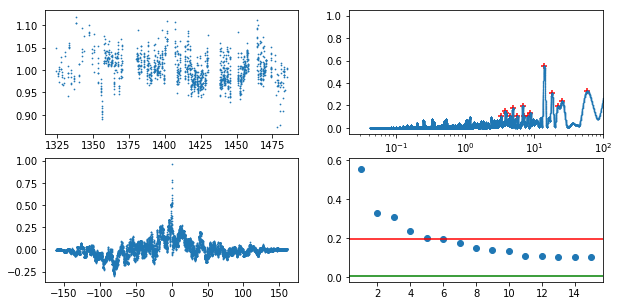

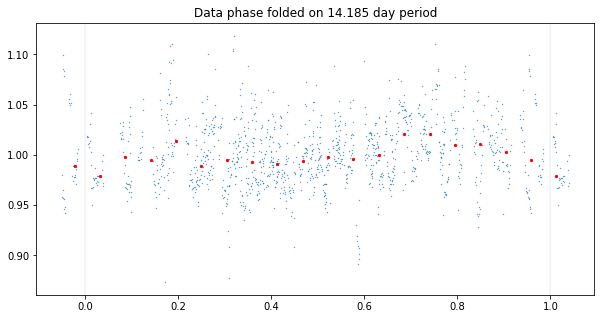

[14.185]
Fourier ok: True
Rejected on Period Range
Is moon: False
[14.185]
74: True


In [12]:
dict_ok = {}
for obj in field:
    obj.timeseries_binned = obj.timeseries_binned_old
    obj.flux_binned = obj.flux_binned_old
    obj.flux_binned_err = obj.flux_binned_err_old
    print '*******'
    print obj
    do_plots(obj)
    print obj.cleaned_refined_periods
    fourier_ok = check_fourier_ok(obj, nlim=30)
    print 'Fourier ok:', fourier_ok
    if fourier_ok:
        is_moon = check_moon_detection(obj, new_moon_epoch)
        print 'Is moon:', is_moon
        if is_moon:
            moon_ok = remove_moon_and_check_ok(obj)
            print 'Post removal ok:', moon_ok
            do_plots(obj)
        else:
            moon_ok = True
    dict_ok[obj.obj] = fourier_ok and moon_ok
    print obj.cleaned_refined_periods
for k, v in dict_ok.iteritems():
    print "{}: {}".format(k,v)

In [ ]:
n_peaks = []

for obj in field:
#     n_peaks.append(len(obj.peak_indexes))
    n_peaks.append((obj.obj, len(obj.peak_indexes)))
#     print obj
#     do_plots(obj)
#     print '**************'


In [ ]:
# plt.figure(figsize=(10,5))
# plt.hist(n_peaks, bins=range(min(n_peaks), max(n_peaks) + 1, 1), width=0.9, align='left', edgecolor="k", linewidth=0.5)
# plt.show()

In [ ]:
# objs = [1103, 10640, 8621]

# for o in objs:
#     do_plots(field[o])
#     print field[o].cleaned_refined_periods

#     med, sig = utils.medsig(f)
#     phase_amp = max(binned_data_app) - min(binned_data_app)
#     print 'Phase amplitude {}, {} sigma'.format(phase_amp, phase_amp / sig)

In [ ]:
print sorted(n_peaks, key=lambda x: x[1])

In [ ]:
obj = field[field.objects.keys()[-1]]

In [ ]:

nsigs2keep = [5]
fluxs, ts = [],[]
flux = obj.flux_binned
timeseries = obj.timeseries_binned
med, sig = utils.medsig(flux)
for nsig2keep in nsigs2keep:
    idx_ok = (abs(flux - med) < (nsig2keep * sig)) & (flux != 0.) & ~np.isnan(flux)
    fluxs.append(flux[idx_ok])
    ts.append(timeseries[idx_ok])
for i,t in enumerate(ts):
    plt.scatter(t, fluxs[i], s=0.5)
    plt.show()

In [ ]:
obj.timeseries_binned = ts[0]
obj.flux_binned = fluxs[0]
obj.correlations=None
obj.lag_timeseries=None
obj.calculate_periods_from_autocorrelation(calculate_noise_threshold=False)
do_plots(obj)

In [ ]:
for obj in field:
    if np.any(obj.flux_binned < 0):
        print obj, 'has negative flux values'

In [ ]:
n_peaks = []
sig_ratio = []
objs = []
for obj in field:
    if len(obj.cleaned_refined_periods) > 0:
        p = obj.cleaned_refined_periods[0]
        t = obj.timeseries_binned
        f = obj.flux_binned
        phase_app, data_app = utils.append_to_phase(utils.create_phase(t, p, 0), f)
        binned_phase_app, binned_data_app = utils.bin_phase_curve(phase_app, data_app)
        med, sig = utils.medsig(f)
        phase_amp = max(binned_data_app) - min(binned_data_app)
        sig_ratio.append(phase_amp / sig)
        n_peaks.append(len(obj.peak_indexes))
        objs.append(obj.obj)
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(n_peaks, sig_ratio)
ax.set_xlabel('No of FFT peaks')
ax.set_ylabel('No of sigma from median of most probable variation')
ax.axhline(y=1)
plt.show()

In [ ]:
for b in sorted(zip(objs, zip(n_peaks, sig_ratio)), key=lambda x: x[1][0]):
#     if b[1][1] < 1.0:
    print b

In [ ]:
obj = field[3513]
t = obj.timeseries_binned
f = obj.flux_binned
ferr = obj.flux_binned_err
print obj.cleaned_refined_periods
P = obj.cleaned_refined_periods[0]

In [ ]:
t2r, f2r, ferr2r, sgf = remove_moon_signal(t=t, f=f, ferr=ferr, P=P)

In [ ]:
for obj in field:
    print '**********'
    print obj
    do_plots(obj)
    print '**********'

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(t, f, s=0.1)
ax.scatter(t, sgf, 0.2, c='r')
plt.show()
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(t2r, f2r, s=0.1)
plt.show()

In [ ]:
obj.timeseries_binned = t
obj.flux_binned = f
obj.flux_binned_err = ferr
obj.correlations = None
obj.calculate_periods_from_autocorrelation(calculate_noise_threshold=False)
do_plots(obj)
obj.timeseries_binned = t2r
obj.flux_binned = f2r
obj.flux_binned_err = ferr2r
obj.correlations = None
obj.calculate_periods_from_autocorrelation(calculate_noise_threshold=False)
do_plots(obj)

In [ ]:
ngts_epoch = 2456658.5

In [ ]:
obj.timeseries_binned[0] + ngts_epoch

In [ ]:
full_moon_epoch = 7648.7 + 2450000
new_moon_epoch = 7662.7 + 2450000

In [ ]:
p = obj.cleaned_refined_periods[0]
t = obj.timeseries_binned
f = obj.flux_binned
phase_app, data_app = utils.append_to_phase(utils.create_phase(t+ ngts_epoch, p, new_moon_epoch), f)
binned_phase_app, binned_data_app = utils.bin_phase_curve(phase_app, data_app)
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(phase_app, data_app, s=0.1)
ax.scatter(binned_phase_app, binned_data_app, s=5, c='r')
ax.axvline(x=0, lw=0.1, c='k', ls='--')
ax.axvline(x=1, lw=0.1, c='k', ls='--')
ax.set_title('Data phase folded on {} day period'.format(p))
plt.show()

In [ ]:
print new_moon_epoch - ngts_epoch

In [ ]:
np.median(obj.timeseries_binned) + ngts_epoch

In [ ]:
print '{} -> {}'.format(Time(obj.timeseries_binned[0] + ngts_epoch, format='jd').datetime.date(),
                        Time(obj.timeseries_binned[-1] + ngts_epoch, format='jd').datetime.date())

In [ ]:
def create_phaseb(time_series, period, epoch):
    return np.mod(abs(np.array(time_series) - epoch), period) / period

In [ ]:
obj = field[3980]
p = obj.cleaned_refined_periods[0]
t = obj.timeseries_binned
f = obj.flux_binned
fig, ax = plt.subplots(figsize=(10,5))
ax1 = ax.twinx()
ax.scatter(t, f, s=0.1)
ax1.scatter(moon_time, moons, s=1, c='g')
# ax.axvline(x=moon_time[np.argmin(moons)])
ax.axvline(x=974.401004145)
ax.axvline(x=new_moon_epoch)
plt.show()
phase_app, data_app = utils.append_to_phase(utils.create_phase(t, p, new_moon_epoch), f)
binned_phase_app, binned_data_app = utils.bin_phase_curve(phase_app, data_app)
phase_app1, data_app1 = utils.append_to_phase(utils.create_phase(moon_time, p, new_moon_epoch), moons)
binned_phase_app1, binned_data_app1 = utils.bin_phase_curve(phase_app1, data_app1)
fig, ax = plt.subplots(figsize=(10,5))
ax1 = ax.twinx()
ax.scatter(phase_app, data_app, s=0.1)
ax.scatter(binned_phase_app, binned_data_app, s=5, c='r')
ax1.scatter(phase_app1, data_app1, s=1, c='g')
ax1.scatter(binned_phase_app1, binned_data_app1, s=5, c='purple')
ax.axvline(x=0, lw=1, c='k', ls='--')
ax.axvline(x=1, lw=1, c='k', ls='--')
ax.set_title('Data phase folded on {} day period'.format(p))
plt.show()

In [ ]:
moon_epoch = Time(obj.timeseries_binned[np.argmin(moons)] + ngts_epoch, format='jd').datetime
print moon_epoch

In [ ]:
new_moon_epoch = get_new_moon_epoch(obj.timeseries_binned)
for obj in field:
    print '*********'
    print obj
    print check_moon_detection(obj, new_moon_epoch)
    

In [ ]:
new_moon_epoch = get_new_moon_epoch(obj.timeseries_binned)
print new_moon_epoch

In [ ]:
obj_id = obj_list[np.random.randint(0, len(obj_list), size=5)]
# obj_id = [1744] => object when cleaned has 38 day period which looks similar to moon, but rejected by moon filter
print obj_id
field = return_field_from_object_directory(ROOT_DIR, fieldname, test='CYCLE1807', obj_ids=obj_id)